/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Iniciando el pipeline con categorías para predicción de demanda...
Entrenando modelo para categoría: HOBBIES, store_id: CA_1, item_id: HOBBIES_1_001
Número de filas para categoría=HOBBIES y store_id=CA_1: 19410


21:15:49 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1] done processing


Proporción promedio histórica de HOBBIES_1_001 en HOBBIES: 0.0271

Métricas de Error (Nivel de Producto):
- MSE: 1.08
- MAE: 0.80
- R²: -0.02
- NWRMSLE: 0.50
Gráfico guardado como 'predictions_vs_reality_category.png'

Predicciones para los próximos 30 días (Nivel de Producto):
Predicción para 2016-05-23: 0.72 unidades
Predicción para 2016-05-24: 0.71 unidades
Predicción para 2016-05-25: 0.75 unidades
Predicción para 2016-05-26: 0.75 unidades
Predicción para 2016-05-27: 0.80 unidades
Predicción para 2016-05-28: 0.88 unidades
Predicción para 2016-05-29: 0.87 unidades
Predicción para 2016-05-30: 0.79 unidades
Predicción para 2016-05-31: 0.75 unidades
Predicción para 2016-06-01: 0.75 unidades
Predicción para 2016-06-02: 0.70 unidades
Predicción para 2016-06-03: 0.72 unidades
Predicción para 2016-06-04: 0.77 unidades
Predicción para 2016-06-05: 0.74 unidades
Predicción para 2016-06-06: 0.65 unidades
Predicción para 2016-06-07: 0.61 unidades
Predicción para 2016-06-08: 0.62 unidades
Predicc

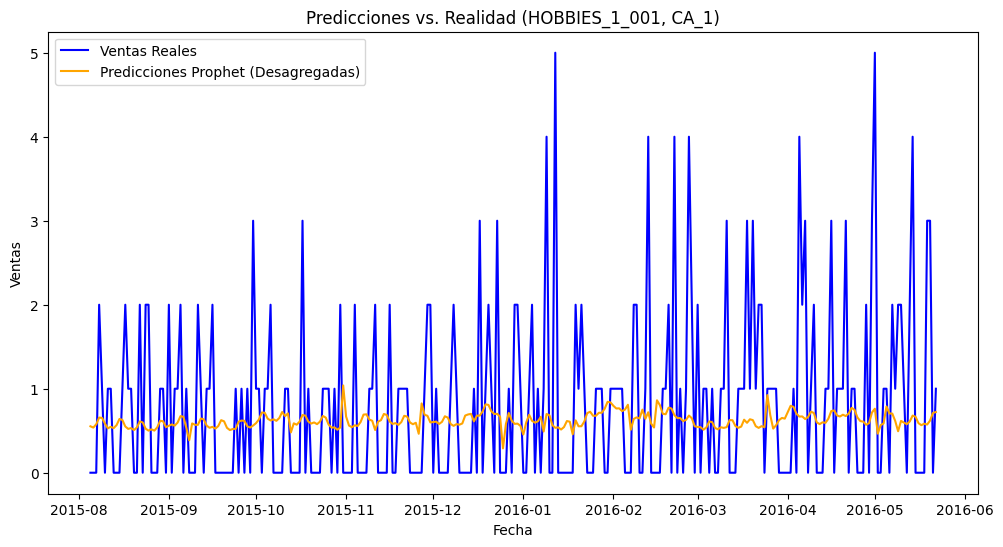

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
import os
from datetime import timedelta

# --- Configuración Inicial ---
print("Iniciando el pipeline con categorías para predicción de demanda...")

# Definir directorios relativos
current_dir = os.getcwd()
data_path = os.path.join(current_dir, "../data/raw/Dataframe_Final_Data_LSTM.csv")
models_dir = os.path.join(current_dir, "../data/models/")
os.makedirs(models_dir, exist_ok=True)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"El archivo {data_path} no se encuentra.")

# Parámetros
category = 'HOBBIES'  # Categoría a predecir
store_id = 'CA_1'
item_id = 'HOBBIES_1_001'  # Producto específico para desagregar
print(f"Entrenando modelo para categoría: {category}, store_id: {store_id}, item_id: {item_id}")

# --- Paso 1: Cargar y Preparar los Datos ---
df = pd.read_csv(data_path, parse_dates=['date'])

# Filtrar por store_id y categoría
df_filtered = df[(df['store_id'] == store_id) & (df['item_id'].str.startswith(category))].copy()
df_filtered = df_filtered.sort_values('date')

# Verificar si hay datos después del filtrado
if df_filtered.empty:
    raise ValueError(f"No hay datos para categoría: {category} y store_id: {store_id}. Verifica los filtros.")
print(f"Número de filas para categoría={category} y store_id={store_id}: {len(df_filtered)}")

# Agrupar por fecha para obtener las ventas totales de la categoría
df_category = df_filtered.groupby('date').agg({
    'sales': 'sum',
    'snap_CA': 'max',  # Tomar el máximo (SNAP es el mismo para todos los productos en un día)
    'sell_price': 'mean',  # Promedio del precio de los productos
    'event_name_1': 'first',  # Tomar el primer evento (es el mismo para todos los productos en un día)
}).reset_index()

# Rellenar fechas faltantes
date_range = pd.date_range(start=df_category['date'].min(), end=df_category['date'].max())
missing_dates = date_range.difference(df_category['date'])
if not missing_dates.empty:
    print(f"Faltan {len(missing_dates)} fechas. Rellenando con ventas = 0.")
    df_missing = pd.DataFrame({
        'date': missing_dates,
        'sales': 0,
        'snap_CA': 0,
        'sell_price': df_category['sell_price'].mean(),
        'event_name_1': 'NoEvent',
    })
    df_category = pd.concat([df_category, df_missing]).sort_values('date').reset_index(drop=True)

# Preparar datos para Prophet
df_prophet = df_category[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
df_prophet['event'] = df_category['event_name_1'].notna().astype(int)
df_prophet['snap'] = df_category['snap_CA']
df_prophet['sell_price'] = df_category['sell_price']

# Asegurarse de que no haya NaN en los regresores
df_prophet['sell_price'] = df_prophet['sell_price'].fillna(df_prophet['sell_price'].mean())
df_prophet['event'] = df_prophet['event'].fillna(0)
df_prophet['snap'] = df_prophet['snap'].fillna(0)

# Dividir en entrenamiento, validación y prueba
train_split = int(0.7 * len(df_prophet))
val_split = int(0.85 * len(df_prophet))
train_data = df_prophet[:train_split]
val_data = df_prophet[train_split:val_split]
test_data = df_prophet[val_split:]

# --- Paso 2: Modelo Prophet para la Categoría ---
model = Prophet(
    yearly_seasonality=20,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=5.0,
    holidays_prior_scale=5.0
)
model.add_regressor('event')
model.add_regressor('snap')
model.add_regressor('sell_price')

# Crear el DataFrame de días festivos
event_days = df_category[df_category['event_name_1'].notna()][['date', 'event_name_1']]
holidays = pd.DataFrame({
    'holiday': event_days['event_name_1'].astype(str),
    'ds': event_days['date'],
    'lower_window': 0,
    'upper_window': 1,
})
holidays = holidays[holidays['holiday'] != 'NoEvent']
model.holidays = holidays
model.fit(train_data)

# --- Paso 3: Predicciones a Nivel de Categoría ---
# Validación
future_val = val_data[['ds', 'event', 'snap', 'sell_price']]
forecast_val = model.predict(future_val)
y_val_pred_category = forecast_val['yhat'].values
y_val_true_category = val_data['y'].values

# Prueba
future_test = test_data[['ds', 'event', 'snap', 'sell_price']]
forecast_test = model.predict(future_test)
y_test_pred_category = forecast_test['yhat'].values
y_test_true_category = test_data['y'].values

# Asegurarse de que las predicciones sean no negativas
y_val_pred_category = np.maximum(y_val_pred_category, 0)
y_test_pred_category = np.maximum(y_test_pred_category, 0)

# --- Paso 4: Desagregar Predicciones a Nivel de Producto ---
# Calcular la proporción histórica de ventas de HOBBIES_1_001 dentro de la categoría HOBBIES
df_item = df_filtered[df_filtered['item_id'] == item_id][['date', 'sales']].set_index('date')
df_category_sales = df_category.set_index('date')['sales']
df_combined = df_item.join(df_category_sales.rename('category_sales'), how='left')
df_combined['proportion'] = df_combined['sales'] / df_combined['category_sales']
# Rellenar NaN en proportion (puede ocurrir si category_sales es 0)
df_combined['proportion'] = df_combined['proportion'].fillna(0)
# Calcular la proporción promedio histórica
avg_proportion = df_combined['proportion'].mean()
print(f"Proporción promedio histórica de {item_id} en {category}: {avg_proportion:.4f}")

# Desagregar las predicciones
y_val_pred_item = y_val_pred_category * avg_proportion
y_test_pred_item = y_test_pred_category * avg_proportion

# Obtener las ventas reales de HOBBIES_1_001 para validación y prueba
val_dates = val_data['ds']
test_dates = test_data['ds']
y_val_true_item = df_item.loc[val_dates, 'sales'].values
y_test_true_item = df_item.loc[test_dates, 'sales'].values

# Métricas: R² y NWRMSLE a nivel de producto
mse = mean_squared_error(y_test_true_item, y_test_pred_item)
mae = mean_absolute_error(y_test_true_item, y_test_pred_item)
r2 = r2_score(y_test_true_item, y_test_pred_item)

# Calcular NWRMSLE
weights = np.ones_like(y_test_true_item)
nwrmsle = np.sqrt(np.sum(weights * (np.log1p(y_test_pred_item) - np.log1p(y_test_true_item))**2) / np.sum(weights))
print("\nMétricas de Error (Nivel de Producto):")
print(f"- MSE: {mse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- R²: {r2:.2f}")
print(f"- NWRMSLE: {nwrmsle:.2f}")

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_true_item, label='Ventas Reales', color='blue')
plt.plot(test_dates, y_test_pred_item, label='Predicciones Prophet (Desagregadas)', color='orange')
plt.title(f'Predicciones vs. Realidad ({item_id}, {store_id})')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.savefig('predictions_vs_reality_category.png')
print("Gráfico guardado como 'predictions_vs_reality_category.png'")

# --- Paso 5: Predicciones Futuras ---
future_dates = pd.date_range(start=df_category['date'].max() + timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({'ds': future_dates})
future_df['event'] = 0
future_df['snap'] = 0
future_df['sell_price'] = df_category['sell_price'].mean()
forecast_future = model.predict(future_df)
future_pred_category = np.maximum(forecast_future['yhat'].values, 0)

# Desagregar las predicciones futuras
future_pred_item = future_pred_category * avg_proportion

print("\nPredicciones para los próximos 30 días (Nivel de Producto):")
for date, pred in zip(future_dates, future_pred_item):
    print(f"Predicción para {date.strftime('%Y-%m-%d')}: {pred:.2f} unidades")